# Forecasting - ARIMA

## Intro

ARIMA - AutoRegressive Integrated Moving Average


- ARIMA does not work for all time of time series, e.g., for stock price data there are so many outside factors that much of the data that informs the price is outside features that is not inherent only in the time series data by itself

- ARIMA works well if the data is directly related to the time stamp (e.g., the airline passengers dataset)

- ARIMA is a generalization of an ARMA model (AutoRegressive moving average)

- There is also SARIMA, where the S stands for Seasonal

- There is also SARIMAX, where the X stands for exogenous variables



- ARIMA has parameters p, d, and q 

    - AR component (AutoRegression): parameter p; regression model, that utilizes dependent relationship between current observation and observations over a previous period
    - I component (integrated): parameter q; differencing of observations in order to make the time series stationary
    - MA component (moving average): parameter d: model that uses dependency between observation and residual error from a moving average model applied to lagged observations
    
    
    
Reminder: Stationary mean that the time series has constant mean and variance over time.

Stationary allows to predict mean and variance that will be the same in the future.

Commonly the Augmented Dickey-Fuller test can be used to determine if the dataset is stationary or not. If the dataset is not stationary, one needs to do differencing for example to make the time series stationary. 


### Methods of choosing p, d and q:

- Method 1): Use ACF and PACF plots, but they can be difficult to read
- Method 2): Grid Search --> takes time. Run ARIMA on different combinations and p, d and q
    - Due to computational power increasing, it is becoming more and more popular
    - Usually this is more accurate than reading values by oneself
    
    
## AR Models - Autoregression model

In an AR model, we forecast using a linear combination of past values of the variable. Autoregression refers to a regression of the variable against itself. It is run against a set of lagged values of order p. The autoregressive model specifies that the output varible depends linearly on its own previous values and on a stochastic term.

$$y_t = c + \phi_1 y_{t-1}+ \phi_2 y_{t-2} + ... +  \phi_p y_{t-p} + \epsilon_t$$

where 

- $p$: order p
- $\phi$: lag coefficient
- $\epsilon_t$: white noise
- $c$: constant

Autoregression has many orders, one can have AR(Order 1) model which is only $y_t = c + \phi_1 y_{t-1}$, order 2 is $y_t = c + \phi_1 y_{t-1}+ \phi_2 y_{t-2}$, and so on. In principle, going back further lags might allow the model to fit the series better (more historical information), but there is a sweespot, which going beyond means that too much noise gets introduced that is no longer relevant for the prediction.

High order AR models can become complex, statsmodels choses the order for us. 

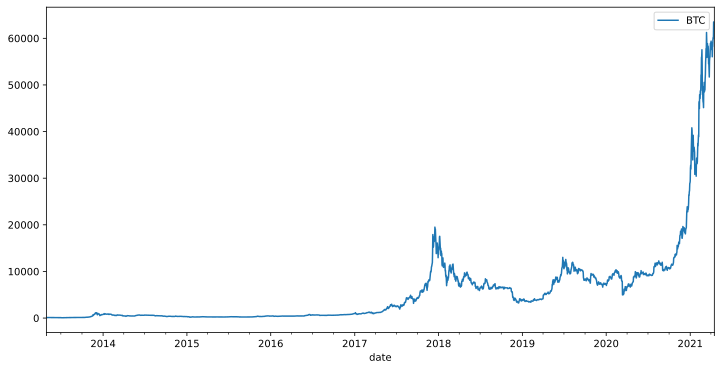

In [68]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-04-18/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_uspop = pd.read_csv(f"{path}uspopulation.csv", parse_dates=True, index_col='DATE')
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)

# AR Model with statsmodels

In [69]:
from statsmodels.tsa.ar_model import AR, ARResults

In [70]:
data_uspop.index.freq = 'MS' # month start
data_uspop

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699
...,...
2018-08-01,327698
2018-09-01,327893
2018-10-01,328077


In [71]:
data_uspop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2011-01-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PopEst  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


<AxesSubplot:xlabel='DATE'>

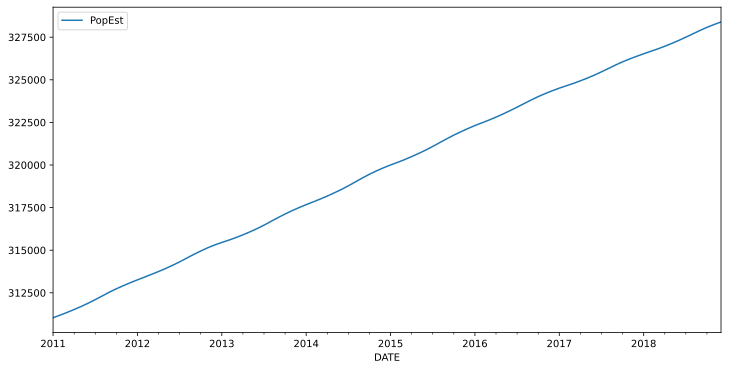

In [72]:
data_uspop.plot(figsize=(12,6))

This dataset has a very strong trend, one could draw a simple linear regression line to forecast future value.

In [73]:
data_uspop.shape

(96, 1)

We have 96 months of training.

In [74]:
train = data_uspop.iloc[:84] # first 84 months
test = data_uspop.iloc[84:]

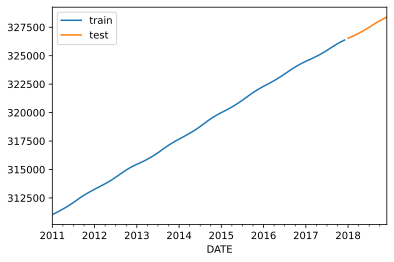

In [75]:
fig, ax = plt.subplots()
train['PopEst'].plot(ax=ax, legend=True, label='train')
test['PopEst'].plot(ax=ax, legend=True, label='test')
plt.legend()
plt.show()

In [76]:
import warnings
warnings.filterwarnings("ignore") # little red warnings get ignored

## AR Order 1 Model 

Look back one timestep.

In [77]:
model = AR(train["PopEst"])
AR1fit = model.fit(maxlag=1) # different methods / solvers are available and tunable

In [78]:
AR1fit.k_ar # order of this AR model

1

In [79]:
AR1fit.params

const        284.913797
L1.PopEst      0.999686
dtype: float64

Returns the constant term and the coefficient, see the formula $$y_t = c + \phi_1 y_{t-1} + \epsilon_t$$

In [80]:
start = len(train)
end = len(train) + len(test) - 1 # one right before the length of the total dataframe
start, end

(84, 95)

In [81]:
AR1fit.predict(start=start, end=end) # predictions on the test set

2018-01-01    326560.403377
2018-02-01    326742.749463
2018-03-01    326925.038278
2018-04-01    327107.269838
2018-05-01    327289.444162
2018-06-01    327471.561268
2018-07-01    327653.621173
2018-08-01    327835.623896
2018-09-01    328017.569455
2018-10-01    328199.457868
2018-11-01    328381.289152
2018-12-01    328563.063326
Freq: MS, dtype: float64

In [82]:
predictions1 = AR1fit.predict(start=start, end=end) # predictions on the test set, order 1
predictions1 = predictions1.rename('AR(1) Predictions')
predictions1

2018-01-01    326560.403377
2018-02-01    326742.749463
2018-03-01    326925.038278
2018-04-01    327107.269838
2018-05-01    327289.444162
2018-06-01    327471.561268
2018-07-01    327653.621173
2018-08-01    327835.623896
2018-09-01    328017.569455
2018-10-01    328199.457868
2018-11-01    328381.289152
2018-12-01    328563.063326
Freq: MS, Name: AR(1) Predictions, dtype: float64

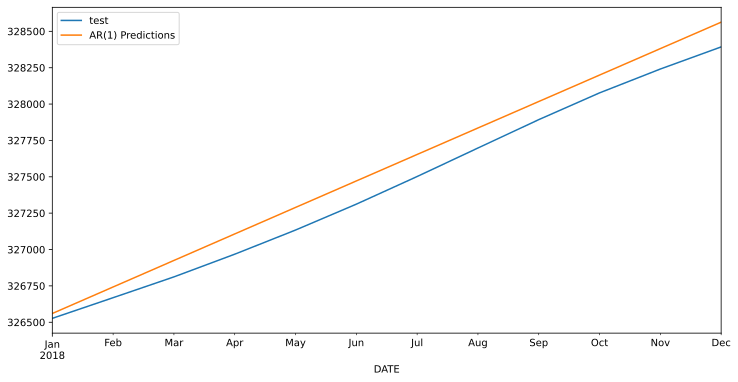

In [83]:
test['PopEst'].plot(figsize=(12,6), legend=True, label='test')
predictions1.plot(legend=True, label=predictions1.name)
plt.show()

## AR Order 2Model 

Look back two timesteps (month).

In [84]:
model = AR(train["PopEst"])
AR2fit = model.fit(maxlag=2)
AR2fit.params

const        137.368305
L1.PopEst      1.853490
L2.PopEst     -0.853836
dtype: float64

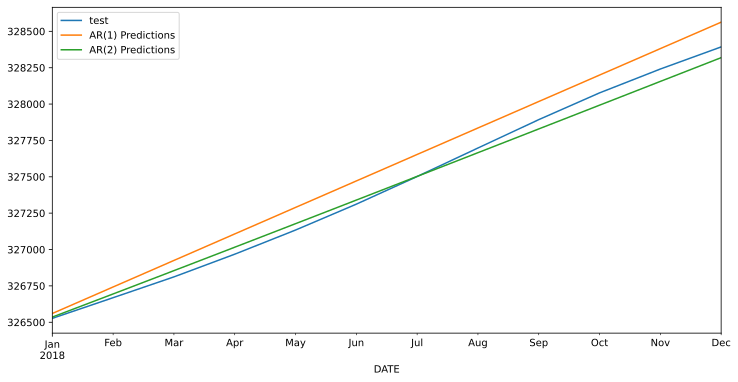

In [85]:
predictions2 = AR2fit.predict(start, end)
predictions2 = predictions2.rename("AR(2) Predictions")
test['PopEst'].plot(figsize=(12,6), legend=True, label='test')
predictions1.plot(legend=True)
predictions2.plot(legend=True)
plt.show()

## AR Order 4 Model 

Look back four timesteps (month).

In [86]:
model = AR(train["PopEst"])
AR2fit = model.fit(maxlag=4)
AR2fit.params

const        113.461933
L1.PopEst      2.470586
L2.PopEst     -2.095342
L3.PopEst      0.482154
L4.PopEst      0.142418
dtype: float64

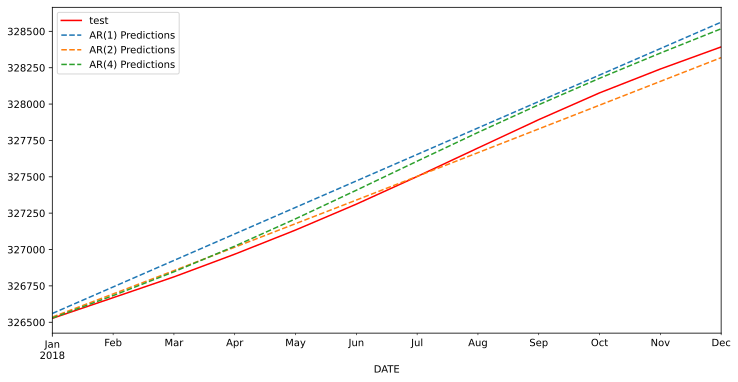

In [87]:
predictions4 = AR2fit.predict(start, end)
predictions4 = predictions4.rename("AR(4) Predictions")
test['PopEst'].plot(figsize=(12,6), legend=True, label='test', color='red')
predictions1.plot(legend=True, linestyle='dashed')
predictions2.plot(legend=True, linestyle='dashed')
predictions4.plot(legend=True, linestyle='dashed')
plt.show()

## Let statsmodel decide what the best lag is

In [88]:
model = AR(train["PopEst"])
ARfit = model.fit(ic='t-stat') # criterion used for optimal lag length, aic is often the best, but it depends
ARfit.params

const        82.309677
L1.PopEst     2.437997
L2.PopEst    -2.302100
L3.PopEst     1.565427
L4.PopEst    -1.431211
L5.PopEst     1.125022
L6.PopEst    -0.919494
L7.PopEst     0.963694
L8.PopEst    -0.439511
dtype: float64

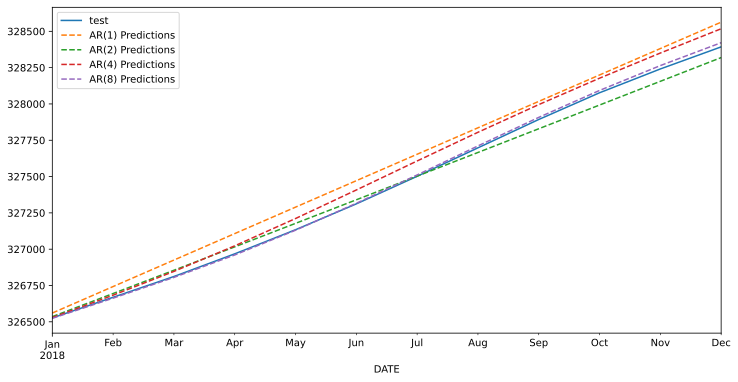

In [89]:
predictions = ARfit.predict(start, end)
predictions = predictions.rename("AR(8) Predictions")
test['PopEst'].plot(figsize=(12,6), legend=True, label='test')
predictions1.plot(legend=True, linestyle='dashed')
predictions2.plot(legend=True, linestyle='dashed')
predictions4.plot(legend=True, linestyle='dashed')
predictions.plot(legend=True, linestyle='dashed')
plt.show()

In [90]:
from sklearn.metrics import mean_squared_error

In [91]:
labels = ['AR1', 'AR2', 'AR4', 'AR8']
preds = [predictions1, predictions2, predictions4, predictions]

In [66]:
for ii in range(len(labels)):
    error = np.sqrt(mean_squared_error(test['PopEst'], preds[ii]))
    print(f"{labels[ii]} error RMSE was: {error:.2f}")

AR1 error RMSE was: 132.10
AR2 error RMSE was: 52.09
AR4 error RMSE was: 86.67
AR8 error RMSE was: 13.67


## With bitcoin data

In [101]:
train = BTC.iloc[:-90]
test = BTC.iloc[-90:]
start = len(train)
end = len(train) + len(test) - 1 # one right before the length of the total dataframe

model = AR(train["BTC"])
ARfit = model.fit(ic='t-stat') # criterion used for optimal lag length, aic is often the best, but it depends
ARfit.params

const     -1.910768
L1.BTC     1.120087
L2.BTC    -0.191056
L3.BTC     0.058551
L4.BTC    -0.001508
L5.BTC     0.100162
L6.BTC    -0.087459
L7.BTC     0.040964
L8.BTC     0.010459
L9.BTC    -0.109730
L10.BTC    0.118680
L11.BTC    0.002073
L12.BTC   -0.021523
L13.BTC   -0.093733
L14.BTC    0.072057
L15.BTC   -0.031926
L16.BTC   -0.039537
L17.BTC    0.088483
L18.BTC   -0.050621
L19.BTC    0.156974
L20.BTC   -0.073100
L21.BTC   -0.097227
L22.BTC    0.065192
L23.BTC   -0.074221
L24.BTC   -0.024630
L25.BTC    0.078412
L26.BTC   -0.016266
L27.BTC   -0.044608
L28.BTC    0.047782
dtype: float64

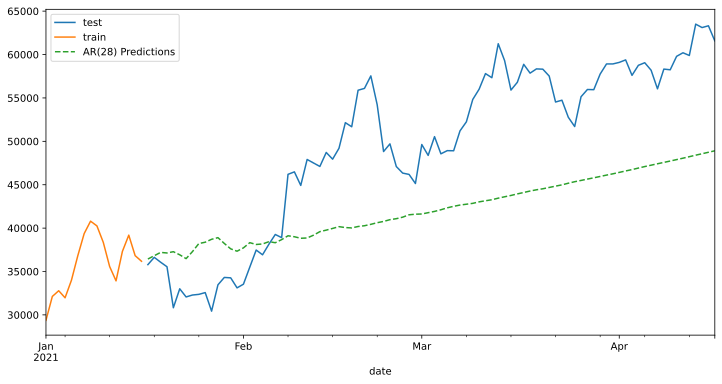

In [105]:
predictions = ARfit.predict(start, end)
predictions = predictions.rename("AR(28) Predictions")
test['BTC'].plot(figsize=(12,6), legend=True, label='test')
train['BTC'].loc["2021"].plot(legend=True, label='train')
predictions.plot(legend=True, linestyle='dashed')
plt.show()

# Forecast

In [107]:
model = AR(data_uspop["PopEst"])
ARfit = model.fit() # criterion used for optimal lag length, aic is often the best, but it depends
ARfit.params

const         84.885175
L1.PopEst      2.296674
L2.PopEst     -2.109518
L3.PopEst      1.429221
L4.PopEst     -1.259837
L5.PopEst      1.093852
L6.PopEst     -0.985774
L7.PopEst      1.066295
L8.PopEst     -0.858709
L9.PopEst      0.826672
L10.PopEst    -1.074975
L11.PopEst     1.034535
L12.PopEst    -0.458679
dtype: float64

In [115]:
forecast = ARfit.predict(start=data_uspop.shape[0], end=data_uspop.shape[0]+12) # predict 12 months into the future
forecast = forecast.rename("forecast")


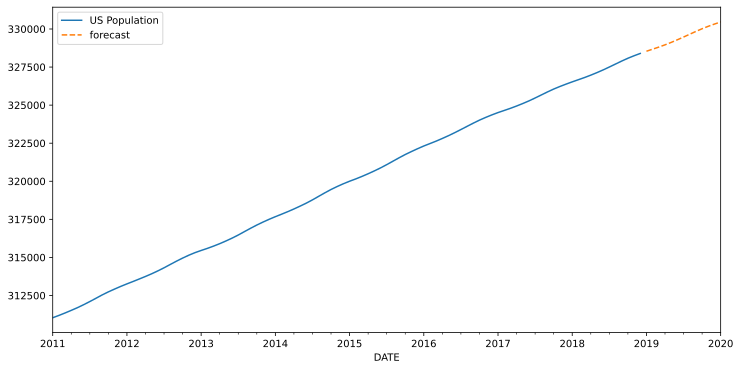

In [116]:
data_uspop['PopEst'].plot(figsize=(12,6), legend=True, label='US Population')
forecast.plot(legend=True, linestyle='dashed')
plt.show()